In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# 加载Olivetti Face数据集
olivetti_faces = fetch_olivetti_faces(shuffle=True)
X, y = olivetti_faces.data, olivetti_faces.target

In [19]:
# 转换为PyTorch张量
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [20]:
# 划分训练集和测试集(80% 训练, 20% 测试)
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = random_split(TensorDataset(X_tensor, y_tensor), [train_size, test_size])

In [21]:
# 数据加载器
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
# 定义优化的神经网络
class OptimizedFaceNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super(OptimizedFaceNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4096, 512),
            nn.BatchNorm1d(512),
            activation_fn,
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            activation_fn,
            nn.Dropout(0.3),
            nn.Linear(256, 40)
        )

    def forward(self, x):
        return self.model(x)

In [24]:
# 训练函数（支持不同优化器）
def train_model(model, train_loader, optimizer, epochs=20):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    train_hist = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        train_hist.append(avg_loss)

    return train_hist


In [25]:
# 测试函数
def test_acc(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    acc = correct / total * 100
    return acc

In [26]:
# 定义不同优化器
optimizers = {
    "GD": lambda model: optim.SGD(model.parameters(), lr=0.01),
    "BGD": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    "MBGD": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True),
    "SGD": lambda model: optim.SGD(model.parameters(), lr=0.01),
    "RMSPROP": lambda model: optim.RMSprop(model.parameters(), lr=0.01),
    "ADAM": lambda model: optim.Adam(model.parameters(), lr=0.01),
    "ADAMW": lambda model: optim.AdamW(model.parameters(), lr=0.01)
}

In [27]:
# 训练所有优化器
train_results = {}
test_results = {}

for opt_name, opt_func in optimizers.items():
    print(f"\nTraining with {opt_name}")
    model = OptimizedFaceNN().to(device)
    optimizer = opt_func(model)
    train_results[opt_name] = train_model(model, train_loader, optimizer, epochs=10)
    
    # 测试模型并记录准确率
    test_results[opt_name] = test_acc(test_loader, model)
    print(f"{opt_name} Test Accuracy: {test_results[opt_name]:.2f}%")


Training with GD
Epoch [1/10], Loss: 3.3340
Epoch [2/10], Loss: 2.5927
Epoch [3/10], Loss: 2.1890
Epoch [4/10], Loss: 1.8396
Epoch [5/10], Loss: 1.5732
Epoch [6/10], Loss: 1.3346
Epoch [7/10], Loss: 1.1307
Epoch [8/10], Loss: 0.9639
Epoch [9/10], Loss: 0.8460
Epoch [10/10], Loss: 0.6978
GD Test Accuracy: 92.50%

Training with BGD
Epoch [1/10], Loss: 3.1798
Epoch [2/10], Loss: 2.0846
Epoch [3/10], Loss: 1.4481
Epoch [4/10], Loss: 0.8098
Epoch [5/10], Loss: 0.6008
Epoch [6/10], Loss: 0.4270
Epoch [7/10], Loss: 0.3453
Epoch [8/10], Loss: 0.2954
Epoch [9/10], Loss: 0.2905
Epoch [10/10], Loss: 0.2335
BGD Test Accuracy: 88.75%

Training with MBGD
Epoch [1/10], Loss: 3.1731
Epoch [2/10], Loss: 2.0610
Epoch [3/10], Loss: 1.1867
Epoch [4/10], Loss: 0.7975
Epoch [5/10], Loss: 0.6087
Epoch [6/10], Loss: 0.3874
Epoch [7/10], Loss: 0.3149
Epoch [8/10], Loss: 0.2675
Epoch [9/10], Loss: 0.1925
Epoch [10/10], Loss: 0.2093
MBGD Test Accuracy: 90.00%

Training with SGD
Epoch [1/10], Loss: 3.3140
Epoch 

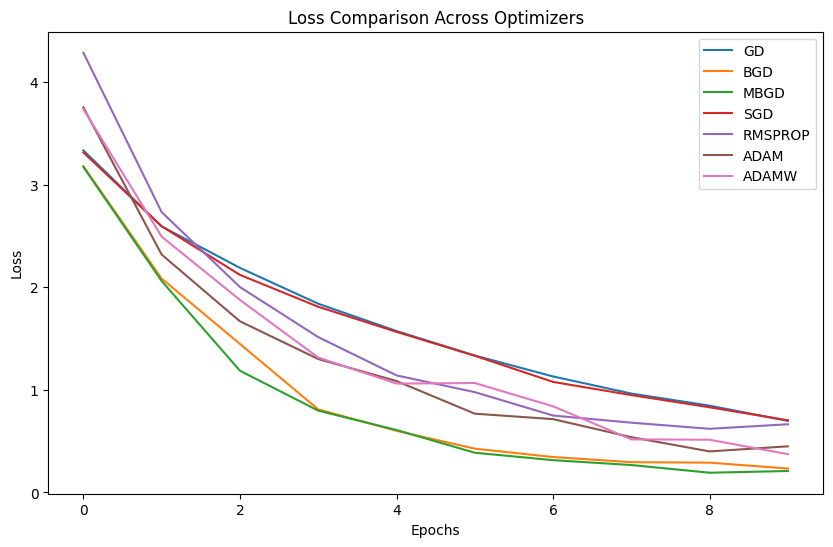

In [28]:
# 画出不同优化器的Loss曲线
plt.figure(figsize=(10, 6))
for opt_name, hist in train_results.items():
    plt.plot(hist, label=opt_name)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison Across Optimizers")
plt.legend()
plt.show()

In [29]:
# 打印所有优化器的最终准确率
print("\nFinal Test Accuracy Comparison:")
for opt_name, acc in test_results.items():
    print(f"{opt_name}: {acc:.2f}%")


Final Test Accuracy Comparison:
GD: 92.50%
BGD: 88.75%
MBGD: 90.00%
SGD: 93.75%
RMSPROP: 52.50%
ADAM: 83.75%
ADAMW: 73.75%
